# Decision System

Dataset loading - Extraction

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
  
# Fetch dataset from UCI repo
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# Split into features and target
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# Metadata 
print(statlog_german_credit_data.metadata) 
  
# Variable information 
print(statlog_german_credit_data.variables) 

# Rename columns for better understanding
X = X.rename(columns={
    # Categorical features
    'Attribute1': 'checking_account_status',
    'Attribute3': 'credit_history',
    'Attribute4': 'purpose',
    'Attribute6': 'savings_account',
    'Attribute7': 'employment_since',
    'Attribute9': 'personal_status_sex',
    'Attribute10': 'other_debtors',
    'Attribute12': 'property',
    'Attribute14': 'other_installment_plans',
    'Attribute15': 'housing',
    'Attribute17': 'job',
    'Attribute19': 'telephone',
    'Attribute20': 'foreign_worker',
    
    # Numerical features
    'Attribute2': 'duration_months',
    'Attribute5': 'credit_amount',
    'Attribute8': 'installment_rate',
    'Attribute11': 'residence_since',
    'Attribute13': 'age',
    'Attribute16': 'num_existing_credits',
    'Attribute18': 'num_dependents'
})

X.head()


{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,num_existing_credits,job,num_dependents,telephone,foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


Data Preprocessing - Transformation

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Feature identification
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()
print(categorical_features)
numerical_features = X.select_dtypes(include = ['int64']).columns.tolist()
print(numerical_features)

# Data Preprocessing
preprocessor_scaled = ColumnTransformer( # Scaling needed for logistic regression
	transformers = [
		('num', StandardScaler(), numerical_features), # Scale num features
		('cat', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), categorical_features), # OneHotEncode cat features. Handle unknown to make sure pipeline doesnt work on any unseen cat with new data
	]
)

preprocessor_passthrough = ColumnTransformer( # No need for scaling in RandomForest
	transformers = [
		('num', 'passthrough', numerical_features), # Passthrough direct values
		('cat', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), categorical_features) # OneHotEncoding still needed
	]
)

# Data Ingestion onto Model
pipelines = {
	'log_reg': Pipeline ([('prep', preprocessor_scaled), ('model', LogisticRegression(max_iter = 1000))]),
	'rf': Pipeline([('prep', preprocessor_passthrough), ('model', RandomForestClassifier(random_state = 42))])
}

['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
['duration_months', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'num_existing_credits', 'num_dependents']


Model Evaluation

In [3]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
# Reshaping y
y = np.ravel(y) # y is a 2D array, scikit-learn expects a 1D array.
y = y - 1  # Because we convert values from (2 -> 1, 1 -> 0)

# Check class distribution
print('Class distribution (imbalanced dataset):')
print(np.unique(y, return_counts = True))

# Split data with transformed y
X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size = 0.2, # 0.8 train, 0.2 test
	random_state = 42, # Random seed of 42
	stratify = y # 70/30 ratio of imbalanced data is maintained in both train and test sets
)

# Model evaluation with transformed target
for name, pipe in pipelines.items():
	pipe.fit(X_train, y_train)
	proba = pipe.predict_proba(X_test)[:, 1] # Get probability of default. [:, 1] because we are only interested in default, instead of no default [:, 0]
	pred = (proba >= 0.5).astype(int) # Converts array of predicted probabilities from Boolean into 0/1. needed for the classification report
	print(name, f'AUC: {roc_auc_score(y_test, proba):.3f}') # AUC measures how well model separates defaulters vs no-defaulters across all possible thresholds
	print(classification_report(y_test, pred, zero_division = 0)) # We test on y_test as this is the unseen target data


Class distribution (imbalanced dataset):
(array([0, 1]), array([700, 300]))
log_reg AUC: 0.804
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200

rf AUC: 0.797
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       140
           1       0.71      0.42      0.53        60

    accuracy                           0.78       200
   macro avg       0.75      0.67      0.69       200
weighted avg       0.77      0.78      0.75       200



Model evaluation results: (0 = non-default, 1 = default)
Log_reg had a slightly higher accuracy across different thresholds. 
Precision:
- Whilst log reg is better at predicting the non-defaults, rf is more precise at predicting the defaults
Recall (for 1: how many actual bad borrowers where correctly flagged):
- Whilst both models are not very good at predicting the defaults (53, 42), log_reg is still slightly superior. 
F1-score (combined measure of catching bad borrowers without over-flagging good ones)
These results are typical for imbalanced datasets - more default data is needed.

Feature Importance on Models

Helpers: get feature names from a pipeline

In [4]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

def get_feature_names_from_pipeline(pipe, X_sample: pd.DataFrame):
    """
    Returns the post-transformer feature names as seen by the final estimator.
    Works when the pipeline contains a ColumnTransformer with transformers
    that implement get_feature_names_out (e.g., OneHotEncoder, StandardScaler).
    Falls back gracefully if not available.
    """
    # Try to find the ColumnTransformer in the pipeline
    ct = None
    for step_name, step in pipe.named_steps.items():
        if isinstance(step, ColumnTransformer):
            ct = step
            break

    if ct is None:
        # No column transformer → features are as in X
        return np.array(X_sample.columns)

    feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if trans == 'drop':
            continue
        # Resolve nested pipelines
        final_trans = trans
        if hasattr(trans, 'named_steps'):
            final_trans = trans.named_steps.get(list(trans.named_steps.keys())[-1], trans)

        if hasattr(final_trans, 'get_feature_names_out'):
            try:
                names = final_trans.get_feature_names_out(cols)
            except TypeError:
                # Some transformers expect no args
                names = final_trans.get_feature_names_out()
        else:
            # If transformer doesn't expose names, fall back to raw column names
            names = np.array(cols if isinstance(cols, (list, tuple, np.ndarray)) else [cols])

        feature_names.extend(list(names))

    # Handle 'remainder=passthrough'
    if getattr(ct, 'remainder', None) == 'passthrough':
        used = []
        for _, _, cols in ct.transformers_:
            if isinstance(cols, (list, tuple, np.ndarray)):
                used += list(cols)
            else:
                used.append(cols)
        remainder_cols = [c for c in X_sample.columns if c not in used]
        feature_names.extend(list(remainder_cols))

    return np.array(feature_names)

Model-specific importance (LR & RF)

In [5]:
def model_specific_importance(pipe, X_sample: pd.DataFrame):
    """
    Returns a DataFrame of model-specific importances aligned to feature names.
    - LogisticRegression: absolute coefficients (also return signed coef for inspection)
    - RandomForest: feature_importances_
    """
    feat_names = get_feature_names_from_pipeline(pipe, X_sample)
    est = pipe[-1]  # final estimator

    if hasattr(est, "coef_"):  # LogisticRegression, LinearSVC (with probas off), etc.
        coef = est.coef_.ravel()
        imp = np.abs(coef)
        df = pd.DataFrame({
            "feature": feat_names,
            "importance": imp,
            "coef_signed": coef
        }).sort_values("importance", ascending=False)
        df.attrs["kind"] = "coef_abs"
        return df

    if hasattr(est, "feature_importances_"):  # Tree-based models
        imp = est.feature_importances_.ravel()
        df = pd.DataFrame({
            "feature": feat_names,
            "importance": imp
        }).sort_values("importance", ascending=False)
        df.attrs["kind"] = "gini_importance"
        return df

    raise ValueError(f"Estimator {type(est).__name__} does not expose model-specific importance.")

Permutation importance (model-agnostic, recommended)

In [6]:
from sklearn.inspection import permutation_importance
import pandas as pd

def permutation_importance_raw(pipe, X_eval, y_eval, n_repeats=10, random_state=42, scoring="roc_auc"):
    r = permutation_importance(pipe, X_eval, y_eval,
                               n_repeats=n_repeats, random_state=random_state,
                               scoring=scoring, n_jobs=-1)
    feat_names = X_eval.columns  # raw columns match r.importances_ shape
    df = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)
    df.attrs["kind"] = f"permutation_raw_{scoring}"
    return df

Run in models

In [ ]:
all_results = {}

for name, pipe in pipelines.items():
    # Fit on train
    pipe.fit(X_train, y_train)

    # Model-specific importance
    try:
        ms_imp = model_specific_importance(pipe, X_train)
        all_results[(name, "model_specific")] = ms_imp.head(30)
        print(f"\n{name} — Model-specific top 10:\n", ms_imp.head(10))
    except ValueError as e:
        print(f"\n{name} — Model-specific importance not available: {e}")

# Permutation importance on test (safer for pipelines)
pi_imp_raw = permutation_importance_raw(pipe, X_test, y_test, scoring="roc_auc")
print(pi_imp_raw.head(15))


log_reg — Model-specific top 10:
                          feature  importance  coef_signed
9    checking_account_status_A14    1.498888    -1.498888
25           savings_account_A64    1.113574    -1.113574
13            credit_history_A34    1.098474    -1.098474
14                   purpose_A41    1.086028    -1.086028
26           savings_account_A65    0.992211    -0.992211
42                  housing_A153    0.941179    -0.941179
47           foreign_worker_A202    0.919363    -0.919363
38                 property_A124    0.903920     0.903920
32       personal_status_sex_A93    0.784868    -0.784868
40  other_installment_plans_A143    0.757775    -0.757775

rf — Model-specific top 10:
                          feature  importance
1                  credit_amount    0.111460
4                            age    0.091264
0                duration_months    0.089464
9    checking_account_status_A14    0.066035
2               installment_rate    0.042255
3                residence_

Log-reg:
Learned that lack of financial history, liquidity buffers, or collateral (no checking, no savings, no property) is the strongest predictor of credit default.
Random forest:
Emphasizes monetary and duration variables (credit amount, loan duration, age) as major drivers. 

This makes sense, trees can capture non-linear relationships (eg. risk increasing sharply after certain loan sizes), whereas LR interprets 
categorical risk thresholds more linearly.

Credit risk reality:
Log reg assumes risk increases at a constant rate per unit increase in loan size. 
Not true:
- Small loans - low default prob
- Medium loans (most common) - stable or slightly higher risk
- Large loans - risk increases sharply
- Very large loans (approved only for high-income clients) - possible decrease

/Users/dan/Documents/Documents/Projects/PersonalProjects/credit_decision_system/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


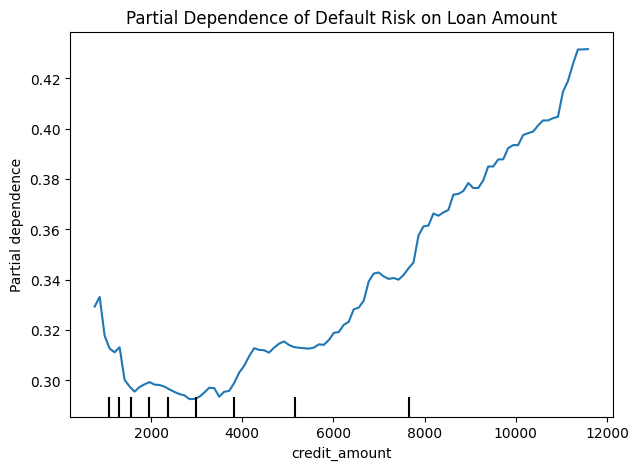

In [28]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

rf_pipe = pipelines["rf"]  # your fitted Random Forest pipeline

# Plot PDP for credit_amount
fig, ax = plt.subplots(figsize=(7, 5))
PartialDependenceDisplay.from_estimator(
    rf_pipe,
    X_test,
    features=["credit_amount"],   # must match the raw column name
    kind="average",               # average effect
    ax=ax
)

ax.set_title("Partial Dependence of Default Risk on Loan Amount")
ax.set_ylabel("Predicted probability of Bad (default)")
ax.set_xlabel("Credit amount (DM)")
plt.show()

Non-linearity of credit amount vs prob of default:
If linear -> flat line (marginal risk impact would be constant) Result: Rate of change of risk with respect to credit amount is not constant
Non-linear relationship:
- Small loans -> low risk
- Medium loans -> stable risk
- Large loans -> sharp rise in risk

Business rules

In [ ]:
# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2)Business rules (robust to missing columns)
def rule_based_score(row):
    s = 0

    # Duration of credit in months
    if 'duration_months' in row:
        dm = row['duration_months']
        if dm >= 60:        s += 25
        elif dm >= 48:      s += 18
        elif dm >= 24:      s += 10

    # Credit amount (larger loans riskier)
    if 'credit_amount' in row:
        ca = row['credit_amount']
        if ca >= 15000:     s += 25
        elif ca >= 8000:    s += 15
        elif ca >= 4000:    s += 8

    # Installment rate (1–4 = % of disposable income; higher = riskier)
    if 'installment_rate' in row:
        ir = row['installment_rate']
        if ir >= 4:         s += 20
        elif ir == 3:       s += 12
        elif ir == 2:       s += 5

    # Present residence since (years; shorter = riskier)
    if 'residence_since' in row:
        rs = row['residence_since']
        if rs <= 1:         s += 10
        elif rs == 2:       s += 5

    # Age (younger = riskier)
    if 'age' in row:
        age = row['age']
        if age < 21:        s += 20
        elif age < 25:      s += 12
        elif age < 30:      s += 6
        elif age > 65:      s += 6   # retirement income risk

    # Num existing credits
    if 'num_existing_credits' in row:
        nec = row['num_existing_credits']
        if nec >= 3:        s += 12
        elif nec == 2:      s += 6

    # Num dependents
    if 'num_dependents' in row:
        nd = row['num_dependents']
        if nd >= 2:         s += 6

    # Checking account status (categorical)
    if 'checking_status' in row:
        val = str(row['checking_status']).lower()
        if '<0' in val or 'no account' in val:     s += 25
        elif '0<=x<200' in val or '0<= <200' in val: s += 12
        elif '>=200' in val:                       s += 2

    # Credit history
    if 'credit_history' in row:
        v = str(row['credit_history']).lower()
        if 'critical' in v or 'delayed previously' in v: s += 25
        elif 'existing paid' in v:                       s += 8
        elif 'all paid duly' in v or 'no credits' in v:  s += 0

    # Savings
    if 'savings' in row:
        v = str(row['savings']).lower()
        if 'little' in v or 'unknown' in v:        s += 12
        elif 'moderate' in v:                       s += 6
        elif 'rich' in v or 'quite rich' in v:      s += 0

    # Employment since (shorter = riskier)
    if 'employment_since' in row:
        v = str(row['employment_since']).lower()
        if 'unemployed' in v or '<1' in v:         s += 18
        elif '1<=x<4' in v:                         s += 10
        elif '4<=x<7' in v:                         s += 4
        elif '>=7' in v:                             s += 0

    # Housing (own < free < rent)
    if 'housing' in row:
        v = str(row['housing']).lower()
        if 'rent' in v:                             s += 8
        elif 'free' in v:                           s += 4

    # Other debtors
    if 'other_debtors' in row:
        v = str(row['other_debtors']).lower()
        if 'none' in v:                             s += 0
        elif 'co-applicant' in v:                   s += 6
        elif 'guarantor' in v:                      s += 4  # mitigates risk slightly

    # Job (unskilled non-resident most risky)
    if 'job' in row:
        v = str(row['job']).lower()
        if 'unskilled' in v and 'non-resident' in v: s += 12
        elif 'unskilled' in v:                        s += 8
        elif 'skilled' in v:                          s += 2
        elif 'management' in v or 'highly qualified' in v: s += 0

    # Telephone (none = slight risk)
    if 'telephone' in row:
        v = str(row['telephone']).lower()
        if 'none' in v or v in {'0', 'no'}:        s += 4

    # Foreign worker (mild penalty in this dataset’s historical context)
    if 'foreign_worker' in row:
        v = str(row['foreign_worker']).lower()
        if v in {'yes', '1', 'true'}:              s += 4

    return s

# Compute rule scores on test set
Xt = X_test.copy()
rule_scores = Xt.apply(rule_based_score, axis=1)

# Normalize rule score to [0,1] (guard against zero division)
rs_min, rs_max = rule_scores.min(), rule_scores.max()
if rs_max > rs_min:
    rule_norm = (rule_scores - rs_min) / (rs_max - rs_min)
else:
    rule_norm = pd.Series(0.0, index=rule_scores.index)

Xt['rule_score'] = rule_scores
Xt['rule_norm']  = rule_norm

Combination of weighted risk scores with model output
(Risk scores = 0.3
Model output = 0.7)

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(Xt)  # probs for both classes
    # select column corresponding to positive class=1 robustly
    pos_idx = list(pipe[-1].classes_).index(1)
    model_prob = proba[:, pos_idx]

    # Weighted final score
    w_model, w_rules = 0.7, 0.3
    final_risk = w_model * model_prob + w_rules * Xt['rule_norm'].to_numpy()

    print(f"\n{name}  |  AUC(model): {roc_auc_score(y_test, model_prob):.3f}  "
          f"|  AUC(hybrid): {roc_auc_score(y_test, final_risk):.3f}")

    # Example thresholding for a quick report (tune threshold later)
    pred = (final_risk >= 0.5).astype(int)
    print(classification_report(y_test, pred, target_names=['Good(0)','Bad(1)'], zero_division=0))


log_reg  |  AUC(model): 0.804  |  AUC(hybrid): 0.807
              precision    recall  f1-score   support

     Good(0)       0.82      0.90      0.86       140
      Bad(1)       0.70      0.55      0.62        60

    accuracy                           0.80       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200


rf  |  AUC(model): 0.797  |  AUC(hybrid): 0.803
              precision    recall  f1-score   support

     Good(0)       0.79      0.92      0.85       140
      Bad(1)       0.69      0.42      0.52        60

    accuracy                           0.77       200
   macro avg       0.74      0.67      0.68       200
weighted avg       0.76      0.77      0.75       200



Hybrid models show slightly better accuracy across different thresholds. 